# Machine Translation

Небольшой проект по переводу текста с русского языка на английский

## 1. Data

Я выбрал корпус текстов OpenSubtitle (http://www.opensubtitles.org/) с ресурса OPUS (https://opus.nlpl.eu/OpenSubtitles/ru&en/v2018/OpenSubtitles)

Раскомментируйте ячейку снизу и запустите ее для скачивания данных или сделайте это вручную

In [1]:
# !wget -q -O data/en-ru.txt.zip https://object.pouta.csc.fi/OPUS-OpenSubtitles/v2018/moses/en-ru.txt.zip
# !unzip data/en-ru.txt.zip -d data
# !mv data/OpenSubtitles.en-ru.en data/en.txt
# !mv data/OpenSubtitles.en-ru.ru data/ru.txt
# !rm data/en-ru.txt.zip
# !rm data/OpenSubtitles.en-ru.ids

Для удобства, все нужные данные я засунул в один `csv` файл. Раскомментируйте ячейку снизу и выполните код

In [2]:
# import pandas as pd

# with open("data/ru.txt", "r") as f_ru, open("data/en.txt", "r") as f_en:
#     ru_lines = [s.strip() for s in f_ru.readlines()]
#     en_lines = [s.strip() for s in f_en.readlines()]

#     pd.DataFrame({"ru": ru_lines, "en": en_lines}).to_csv("data/data.csv", index=False)

In [3]:
import random
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
from torch.utils.data import DataLoader
from torchtext.vocab import Vocab, build_vocab_from_iterator
from torchtext.data.metrics import bleu_score 
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset, Dataset, DatasetDict
import spacy
from typing import List, Literal, Dict, Tuple
import regex
from IPython.display import clear_output
from tqdm.notebook import tqdm

%matplotlib inline

sns.set_style("darkgrid")
sns.set_context("notebook")

Зафиксируем random seed для детерминированности всех процессов

In [4]:
seed = 42

def set_seed(seed: int) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)

Прочитаем данные с помощью библиотеки HuggingFace Datasets, разделим данные на тренировочную (80%), валидационную (10%) и тестовую (10%) выборки

In [5]:
dataset = load_dataset(
    "csv", data_files="data/data.csv", cache_dir="data/cache", split="train[:20%]"
)
dataset

Found cached dataset csv (/home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)


Dataset({
    features: ['ru', 'en'],
    num_rows: 5182021
})

Отфильтруем данные
- Тексты не должны быть пропущены, то есть без `None`
- Уберем тексты с какими-то нестандартными символами

Для этого я подготовил регулярное выражение, которое убирает тексты, содержащие "неправильные" символы

In [6]:
valid_ranges = (r"\u0400-\u04FF", r"\u0000-\u007F", r"\d", r"\p{P}")

valid_pattern = regex.compile(f'^[{"".join(valid_ranges)}]+$')


def filter_symbols(example: dict) -> bool:
    return (
        example["ru"] is not None
        and example["en"] is not None
        and regex.match(valid_pattern, example["ru"]) is not None
        and regex.match(valid_pattern, example["en"]) is not None
    )

In [7]:
dataset = dataset.filter(filter_symbols)

dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-33197ad7bfabeaf2.arrow


Dataset({
    features: ['ru', 'en'],
    num_rows: 5116668
})

In [8]:
def split_dataset(
    dataset: Dataset, valid_size: float, test_size: float, seed: int | None = None
) -> DatasetDict:
    testvalid_size = valid_size + test_size

    train_testvalid = dataset.train_test_split(test_size=testvalid_size, seed=seed)

    test_valid = train_testvalid["test"].train_test_split(
        test_size=(test_size / testvalid_size), seed=seed
    )

    return DatasetDict(
        {
            "train": train_testvalid["train"],
            "valid": test_valid["train"],
            "test": test_valid["test"],
        }
    )

dataset = split_dataset(dataset, valid_size=0.1, test_size=0.1, seed=seed)
dataset

Loading cached split indices for dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-13cababea2ea2213.arrow and /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-95341a14d1820108.arrow
Loading cached split indices for dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-bdd18edf8f746b8a.arrow and /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-28a9c427768288c8.arrow


DatasetDict({
    train: Dataset({
        features: ['ru', 'en'],
        num_rows: 4093334
    })
    valid: Dataset({
        features: ['ru', 'en'],
        num_rows: 511667
    })
    test: Dataset({
        features: ['ru', 'en'],
        num_rows: 511667
    })
})

Просмотрим некоторые примеры из корпуса

In [9]:
example_fragment = dataset["train"][:5]

for i, (ru, en) in enumerate(zip(example_fragment["ru"], example_fragment["en"])):
    print(f"{i + 1}. {ru} --- {en}")

1. Вот, пристрелите пса. --- Here. Shoot the dog.
2. Куда ехать, леди? --- Where to, lady?
3. Я знаю. Но может, это какая-то... Что? --- I know, but... is there some sort of... what?
4. Это меня бесило. --- It's been driving me crazy.
5. Но он дотрагивается до неё только во время медицинского осмотра раз в месяц. --- But he never touches her, except for a monthly checkup.


Посмотрим, как выглядит распределение длин текстов на русском и английском языках. Для этого вначале замапим значения длин в датасет

In [10]:
dataset = dataset.map(
    lambda example: {"ru_len": len(example["ru"]), "en_len": len(example["en"])}
)
dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-2e57b15fd59caf52.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-eacca65f450e0c58.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-9b5bf766db9db33d.arrow


DatasetDict({
    train: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 4093334
    })
    valid: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 511667
    })
    test: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len'],
        num_rows: 511667
    })
})

Хочется визуализировать данные, но сделать это со всем датасетом кажется не лучшим решением ввиду его размеров. Попробуем визуализировать длины текстов на обоих языках для какой-то части данных. Будем держать в голове, что возможны некоторые выбросы, о которых мы позаботимся дальше

In [11]:
def plot_lengths(dataset: Dataset, n_to_show: int, bins: int = 20, log_scale: bool = False):
    _, ax = plt.subplots(1, 2, figsize=(10, 5))

    fragment = dataset[:n_to_show]

    sns.histplot(x=fragment["ru_len"], ax=ax[0], log_scale=log_scale, bins=bins)
    sns.histplot(x=fragment["en_len"], ax=ax[1], log_scale=log_scale, bins=bins)

    ax[0].set_title(f"Russian lengths ({n_to_show} examples)")
    ax[1].set_title(f"English lengths ({n_to_show} examples)")

    ax[0].set_xlabel("Length")
    ax[1].set_xlabel("Length")

    plt.show()

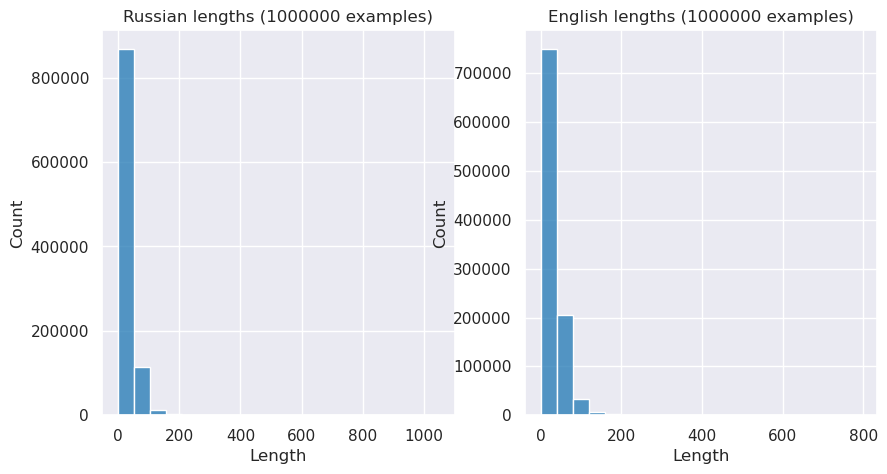

In [12]:
plot_lengths(dataset["train"], n_to_show=1_000_000)

Как видим, большая часть текстов имеет небольшую длину. Посмотрим на некоторые статистики этих распределений: среднее, разброс и 99% перцентиль

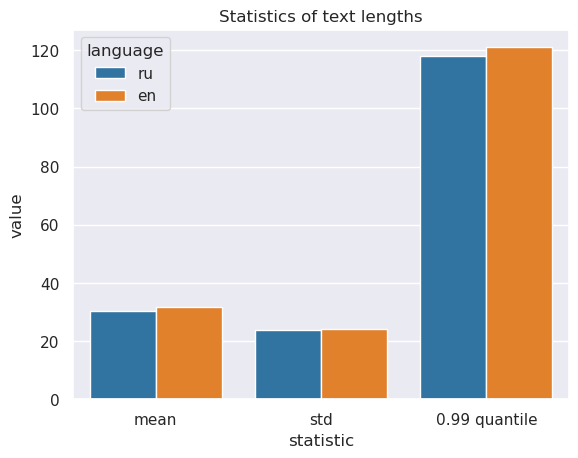

In [13]:
def plot_length_statistics(dataset: Dataset, quantile: float):
    ru_len_array = np.array(dataset["ru_len"])
    en_len_array = np.array(dataset["en_len"])

    len_stats = {"statistic": [], "value": [], "language": []}

    for statistic, name in zip(
        [np.mean, np.std, lambda a: np.quantile(a, quantile)], ["mean", "std", f"{quantile} quantile"]
    ):
        for arr, lang in zip([ru_len_array, en_len_array], ["ru", "en"]):
            len_stats["value"].append(statistic(arr))
            len_stats["statistic"].append(name)
            len_stats["language"].append(lang)

    len_stats = pd.DataFrame(len_stats)

    sns.barplot(len_stats, x="statistic", y="value", hue="language")
    plt.title("Statistics of text lengths")
    plt.show()

plot_length_statistics(dataset["train"], quantile=0.99)

Как видим, распределения довольно похожи. Тексты на английском языке в среднем немного длиннее, чем на русском.

Заметим также, что 99% всех текстов имеют длину менее 125 символов. Оставим только эти короткие тексты, поскольку перед нами не стоит задача создать Google Translator. Мы сконцентрируемся на переводах небольших текстов, состоящих из одного-двух предложений. Также, на всякий случай, отфильтруем данные так, чтобы в них не было пустых текстов

Отфильтруем также и отложенные выборки (валидационную и тестовую), поскольку мы хотим получить адекватные метрики

In [14]:
len_threshold = 125

print("Before filtration")
print(f'Train size: {dataset["train"].num_rows}')
print(f'Valid size: {dataset["valid"].num_rows}')
print(f'Test size: {dataset["test"].num_rows}')


def filter_by_length(example):
    return (
        example["ru_len"] > 0
        and example["en_len"] > 0
        and example["ru_len"] < len_threshold
        and example["en_len"] < len_threshold
    )


dataset["train"] = dataset["train"].filter(filter_by_length)
dataset["valid"] = dataset["valid"].filter(filter_by_length)
dataset["test"] = dataset["test"].filter(filter_by_length)

print("After filtration")
print(f'Train size: {dataset["train"].num_rows}')
print(f'Valid size: {dataset["valid"].num_rows}')
print(f'Test size: {dataset["test"].num_rows}')

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-f0bcb78921761719.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-8699d942ea6f82a9.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-485b7be5fc4fa9f7.arrow


Before filtration
Train size: 4093334
Valid size: 511667
Test size: 511667
After filtration
Train size: 4046118
Valid size: 505886
Test size: 505761


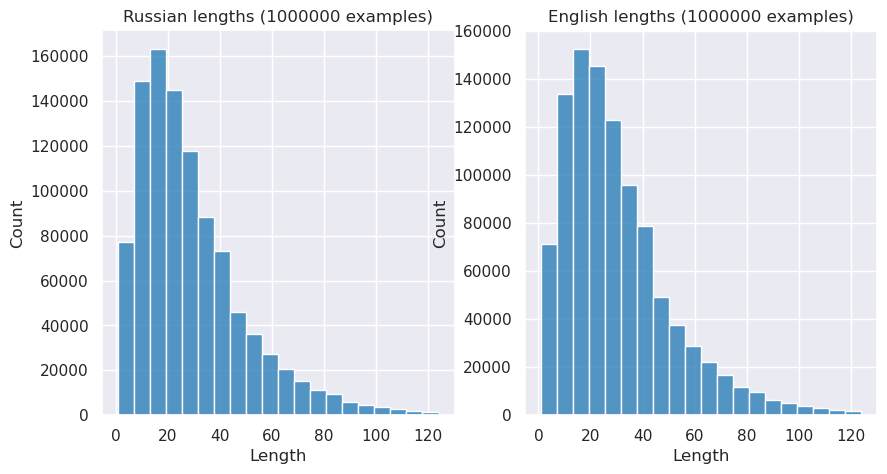

In [15]:
plot_lengths(dataset["train"], n_to_show=1_000_000)

### Токенизация

Для токенизации я буду использовать библиотеку [Spacy](https://spacy.io/).

In [16]:
nlp_ru = spacy.load("ru_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

Для начала я задам специальные токены: 
- `<unk>` - токен для неизвестного символа
- `<pad>` - токен для "набивки" последовательности до определенной длины
- `<sos>` - начало последовательности
- `<eos>` - конец последовательности

In [17]:
unk_token = "<unk>"
pad_token = "<pad>"
sos_token = "<sos>"
eos_token = "<eos>"

special_tokens = [unk_token, pad_token, sos_token, eos_token]

При токенизации я буду добавлять в начало и в конец символы `<sos>` и `<eos>`.
Также для нашей задачи будет целесообразным приводить все тексты (и все токены) к нижнему регистру

In [18]:
def tokenize_ru(s: str) -> List[str]:
    return [sos_token] + [token.text for token in nlp_ru.tokenizer(s.lower())] + [eos_token]


def tokenize_en(s: str) -> List[str]:
    return [sos_token] + [token.text for token in nlp_en.tokenizer(s.lower())] + [eos_token]

Посмотрим примеры токенизации некоторых текстов

In [19]:
for i, (ru, en) in enumerate(zip(example_fragment["ru"], example_fragment["en"])):
    print(f"{i + 1}. {ru} --- {tokenize_ru(ru)}")
    print(f"{en} --- {tokenize_en(en)}")

1. Вот, пристрелите пса. --- ['<sos>', 'Вот', ',', 'пристрелите', 'пса', '.', '<eos>']
Here. Shoot the dog. --- ['<sos>', 'Here', '.', 'Shoot', 'the', 'dog', '.', '<eos>']
2. Куда ехать, леди? --- ['<sos>', 'Куда', 'ехать', ',', 'леди', '?', '<eos>']
Where to, lady? --- ['<sos>', 'Where', 'to', ',', 'lady', '?', '<eos>']
3. Я знаю. Но может, это какая-то... Что? --- ['<sos>', 'Я', 'знаю', '.', 'Но', 'может', ',', 'это', 'какая', '-', 'то', '...', 'Что', '?', '<eos>']
I know, but... is there some sort of... what? --- ['<sos>', 'I', 'know', ',', 'but', '...', 'is', 'there', 'some', 'sort', 'of', '...', 'what', '?', '<eos>']
4. Это меня бесило. --- ['<sos>', 'Это', 'меня', 'бесило', '.', '<eos>']
It's been driving me crazy. --- ['<sos>', 'It', "'s", 'been', 'driving', 'me', 'crazy', '.', '<eos>']
5. Но он дотрагивается до неё только во время медицинского осмотра раз в месяц. --- ['<sos>', 'Но', 'он', 'дотрагивается', 'до', 'неё', 'только', 'во', 'время', 'медицинского', 'осмотра', 'раз', 

Теперь токенизируем все наши тексты

In [20]:
dataset = dataset.map(
    lambda example: {
        "ru_tokens": tokenize_ru(example["ru"]),
        "en_tokens": tokenize_en(example["en"]),
    }
)
dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-3157f9cccdb70ef3.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-beb2756f34c2f9d3.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-f231887384b79783.arrow


DatasetDict({
    train: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens'],
        num_rows: 4046118
    })
    valid: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens'],
        num_rows: 505886
    })
    test: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens'],
        num_rows: 505761
    })
})

Теперь построим словари для обоих языков. Опять же, они будут небольшими, поскольку проект является не самым амбициозным

In [21]:
class TokenVocabIterator:
    def __init__(self, dataset: Dataset, feature_name: str):
        self.dataset = dataset
        self.feature_name = feature_name
        self.i = 0
        self.length = dataset.num_rows

    def __iter__(self):
        return self

    def __next__(self) -> List[str]:
        if self.i < self.length:
            tokens = self.dataset[self.i][self.feature_name]
            self.i += 1
            return tokens
        raise StopIteration

In [22]:
def load_or_build_vocab(dataset: Dataset, lang: Literal["en", "ru"], build_args: Dict = {}) -> Vocab:
    path = f"data/vocab_{lang}.pth"
    if not os.path.exists(path):
        vocab = build_vocab_from_iterator(
            TokenVocabIterator(dataset, f"{lang}_tokens"),
            **build_args
        )

        torch.save(vocab, path)
    else:
        vocab = torch.load(path)
    
    return vocab

In [23]:
vocab_ru = load_or_build_vocab(
    dataset=dataset["train"],
    lang="ru",
    build_args={"specials": special_tokens, "min_freq": 3, "max_tokens": 40_000},
)

In [24]:
vocab_en = load_or_build_vocab(
    dataset=dataset["train"],
    lang="en",
    build_args={"specials": special_tokens, "min_freq": 3, "max_tokens": 30_000},
)

Проверим, что в обоих словарях индексы для специальных токенов совпадают

In [25]:
for token in special_tokens:
    assert vocab_ru.get_stoi()[token] == vocab_en.get_stoi()[token], f"Error! Token {token} is diffenet in two vocabs"

Также достанем индексы для всех этих токенов

In [26]:
unk_index = vocab_ru.get_stoi()[unk_token]
pad_index = vocab_ru.get_stoi()[pad_token]
sos_index = vocab_ru.get_stoi()[sos_token]
eos_index = vocab_ru.get_stoi()[eos_token]

Также в словарях сделаем дефолтным индексом (то есть тем, который словарь будет возвращать на неизвестный токен) значение `unk_index`

In [27]:
vocab_en.set_default_index(unk_index)
vocab_ru.set_default_index(unk_index)

Посмотрим, каких длин получились токены в обоих словарях

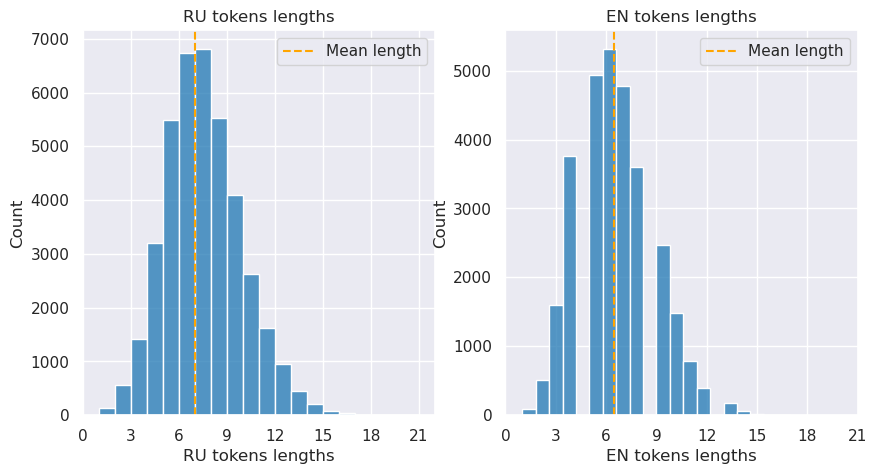

In [28]:
def plot_token_lengths(
    ru_token_lengths: List[int], en_token_lengths: List[int], bins: float = 20
) -> None:

    ru_token_lengths = np.array(ru_token_lengths)
    en_token_lengths = np.array(en_token_lengths)
    ticks = np.arange(0, ru_token_lengths.max() + 1, 3)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.histplot(x=ru_token_lengths, ax=ax[0], bins=bins)
    ax[0].set_xlabel("RU tokens lengths")
    ax[0].set_title("RU tokens lengths")
    ax[0].axvline(ru_token_lengths.mean(), color="orange", linestyle="--", label="Mean length")
    ax[0].set_xticks(ticks)
    ax[0].legend()

    sns.histplot(x=en_token_lengths, ax=ax[1], bins=bins)
    ax[1].set_xlabel("EN tokens lengths")
    ax[1].set_title("EN tokens lengths")
    ax[1].axvline(en_token_lengths.mean(), color="orange", linestyle="--", label="Mean length")
    ax[1].set_xticks(ticks)
    ax[1].legend()
    
    plt.show()

plot_token_lengths(
    ru_token_lengths=[len(s) for s in vocab_ru.get_stoi().keys()],
    en_token_lengths=[len(s) for s in vocab_en.get_stoi().keys()],
)

Как видим, распределения немного отличаются, но в целом похожи.

Интересно также, насколько отличается в среднем количество токенов в двух языках. Для исследования этого отличия, сначала вновь замапим некоторые значения в датасет:
- `ru_tokenized_length`: длина токенизированной последовательности на русском языке
- `en_tokenized_length`: длина токенизированной последовательности на английском языке
  
Также токены переведем в индексы в наших словарях:
- `ru_ids`: последовательность индексов в словаре для русского языка
- `en_ids`: последовательность индексов в словаре для английского языка
  
Причем сделаем это, переведя их сразу же в `torch.Tensor`

In [29]:
dataset = dataset.map(
    lambda example: {
        "ru_tokenized_length": len(example["ru_tokens"]),
        "en_tokenized_length": len(example["en_tokens"]),
        "ru_ids": vocab_ru.lookup_indices(example["ru_tokens"]),
        "en_ids": vocab_en.lookup_indices(example["en_tokens"]),
    }
).with_format(type="torch", columns=["ru_ids", "en_ids"], output_all_columns=True)

dataset

Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-f544d8dc42133b56.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-a9318026f76f606e.arrow
Loading cached processed dataset at /home/ilyas/Documents/study/ml/machine_translation/data/cache/csv/default-ab33a8102828112f/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1/cache-fcda5e62315ff244.arrow


DatasetDict({
    train: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens', 'ru_tokenized_length', 'en_tokenized_length', 'ru_ids', 'en_ids'],
        num_rows: 4046118
    })
    valid: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens', 'ru_tokenized_length', 'en_tokenized_length', 'ru_ids', 'en_ids'],
        num_rows: 505886
    })
    test: Dataset({
        features: ['ru', 'en', 'ru_len', 'en_len', 'ru_tokens', 'en_tokens', 'ru_tokenized_length', 'en_tokenized_length', 'ru_ids', 'en_ids'],
        num_rows: 505761
    })
})

Посмотрим на то, сколько получилось токенов в наших текстах

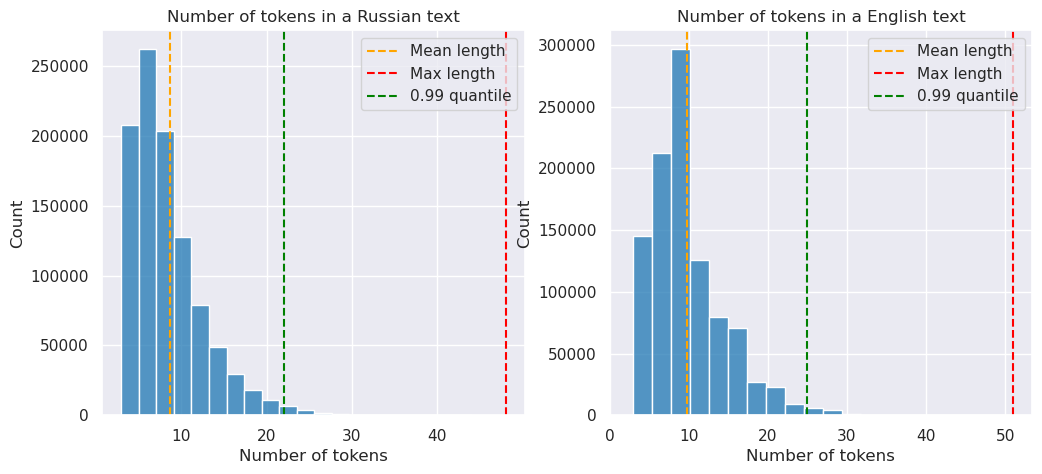

In [30]:
def plot_tokenized_lengths(dataset: Dataset, sample_size: int = 1_000_000):
    ids = np.random.choice(dataset.num_rows, size=sample_size)
    ru_lengths = np.array(dataset["ru_tokenized_length"])
    en_lengths = np.array(dataset["en_tokenized_length"])

    _, ax = plt.subplots(1, 2, figsize=(12, 5))

    for axes, lengths, descr in zip(ax, [ru_lengths, en_lengths], ["Russian", "English"]):
        max_len = lengths.max()
        sns.histplot(lengths[ids], bins=20, ax=axes)
        axes.set_title(f"Number of tokens in a {descr} text")
        axes.set_xlabel("Number of tokens")
        axes.set_xticks(np.arange(max_len, step=10))

        axes.axvline(
            lengths.mean(),
            color="orange",
            linestyle="--",
            label="Mean length",
        )

        axes.axvline(
            max_len,
            color="red",
            linestyle="--",
            label="Max length",
        )

        axes.axvline(
            np.quantile(lengths, q=0.99),
            color="green",
            linestyle="--",
            label="0.99 quantile",
        )

        axes.legend()

    plt.show()


plot_tokenized_lengths(dataset["train"])

Попробуем посмотреть какой-нибудь текст, где такое большое количество токенов

In [31]:
def print_large_texts(dataset: Dataset, threshold: int = 35, num_examples: int = 10, seed: int | None = None):
    ru_lengths = np.array(dataset["ru_tokenized_length"])
    indices = np.argwhere(ru_lengths > threshold).reshape(-1)
    
    if seed is not None:
        np.random.seed(seed)
    
    indices = np.random.choice(indices, size=num_examples)

    for i in indices:
        i = i.item()
        print(f"{i}. {dataset[i]['ru']}")
        print(dataset[i]["en"])        
        print(dataset[i]["ru_tokens"])
        print(dataset[i]["en_tokens"])
        print("******************")

print_large_texts(dataset["train"], num_examples=5, seed=seed)

3345071. Она говорит: " Я в Нью-Йорке, потму что я там никогда не была раньше" "Садись на самолет и возвращайся!" А она: "Я не хочу".
I said , "Get yourself on the pIane.Get back here." She says, "I don't wanna."
['<sos>', 'Она', 'говорит', ':', '"', 'Я', 'в', 'Нью', '-', 'Йорке', ',', 'потму', 'что', 'я', 'там', 'никогда', 'не', 'была', 'раньше', '"', '"', 'Садись', 'на', 'самолет', 'и', 'возвращайся', '!', '"', 'А', 'она', ':', '"', 'Я', 'не', 'хочу', '"', '.', '<eos>']
['<sos>', 'I', 'said', ',', '"', 'Get', 'yourself', 'on', 'the', 'pIane', '.', 'Get', 'back', 'here', '.', '"', 'She', 'says', ',', '"', 'I', 'do', "n't", 'wanna', '.', '"', '<eos>']
******************
2857037. 19, 18, 1 7, 16, 15, 14, 13, 12, 11 , 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0.
19, 18, 1 7, 16, 15, 1 4, 13, 12, 1 1 , ten, nine, eight, seven, six, five, four, three, two, one, zero.
['<sos>', '19', ',', '18', ',', '1', '7', ',', '16', ',', '15', ',', '14', ',', '13', ',', '12', ',', '11', ',', '10', ',', '9', ',', '

Значения вполне приемлемые, просто зачастую в них достаточно много знаков препинания

## 2. Model

Обучать я буду модель `Sequence-to-Sequence`, основанную на рекуррентных нейронных сетях (`RNN`). Она состоит из:
- `Encoder` - часть, которая переводит последовательность id токенов в векторное пространство (embedding)
- `Decoder` - часть, которая по эмбеддингу генерирует новую последовательность
- `Sequence2Sequence` - полная модель, включающая в себя `Encoder` и `Decoder`

### 2.1. Encoder

На вход подается последовательность из id для токенов исходного языка. Encoder преобразует эту последовательность в некоторый вектор, вложенный в пространство меньшей размерности (т.е. эмбеддинг). Поскольку мы будем пользоваться не обычным RNN, а немного более навороченным LSTM, encoder будет отдавать нам пару - `hidden state` и `cell state`. Полученный вектор будет использоваться декодером как вектор "контекста"

In [32]:
class Encoder(nn.Module):

    def __init__(
        self,
        input_size: int,
        embedding_size: int,
        num_layers: int,
        hidden_size: int,
        p_dropout: float = 0,
    ) -> None:
        """
        Constructor for Encoder

        Args:
            input_size (int): size of an input vocabulary
            embedding_size (int): number of features in token embeddings for input vocabulary
            num_layers (int): number of LSTM layers in Encoder
            hidden_size (int): number of features in the hidden state as well as in resulting embedding vector for an input sequence
            p_dropout (float, optional): probability of dropout. Dropout is applied after 
                embedding layer and after every LSTM layer except for the last one.
                Defaults to 0.
        """
        super(Encoder, self).__init__()
        self.input_size = input_size
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.p_dropout = p_dropout

        self.embedding = nn.Embedding(input_size, embedding_size)
        self.dropout = nn.Dropout(p_dropout)

        rnn_dropout = p_dropout if num_layers > 1 else None
        self.rnn = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=rnn_dropout,
            num_layers=self.num_layers,
        )

    def forward(
        self, input: torch.Tensor, lengths: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Forward pass

        Args:
            input (torch.Tensor): input tensor with padded rows of size (batch_size, max_length)
            lengths (torch.Tensor): tensor of actual lengths, (batch_size,)

        Returns:
            torch.Tensor: hidden state of LSTM of size (num_layers, batch_size, hidden_size)
            torch.Tensor: cell state of LSTM of size (num_layers, batch_size, hidden_size)
        """

        # embeds: (batch_size, max_length, embedding_size)
        embeds = self.embedding(input)
        embeds = self.dropout(embeds)

        packed_embeds = pack_padded_sequence(
            embeds, lengths, batch_first=True, enforce_sorted=False
        )

        # output: packed sequence, if unpacked it will be (batch_size, max_length, hidden_size)
        # hidden, cell: (num_layers, batch_size, hidden_size)
        output, (hidden, cell) = self.rnn(packed_embeds)

        return hidden, cell

### 2.2. Decoder

Задача декодера - по в

In [33]:
class Decoder(nn.Module):
    def __init__(
        self,
        embedding_size: int,
        num_layers: int,
        hidden_size: int,
        output_size: int,
        p_dropout: float = 0,
    ) -> None:
        """
        Constructor for Encoder

        Args:
            embedding_size (int): number of features in token embeddings for output vocabulary
            num_layers (int): number of LSTM layers in Decoder
            hidden_size (int): number of features in the hidden state
            output_size (int): size of an output vocabulary
            p_dropout (float, optional): probability of dropout. Dropout is applied after
                embedding layer and after every LSTM layer except for the last one.
                Defaults to 0.
        """
        super(Decoder, self).__init__()
        self.embedding_size = embedding_size
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.p_dropout = p_dropout

        self.embedding = nn.Embedding(
            num_embeddings=output_size, embedding_dim=embedding_size
        )

        self.dropout = nn.Dropout(p=p_dropout)

        rnn_dropout = p_dropout if num_layers > 1 else None
        self.rnn = nn.LSTM(
            input_size=embedding_size,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=rnn_dropout,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(
        self, input: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Forward pass

        Args:
            input (torch.Tensor): input tensor of size (batch_size, 1). For every batch
                there is exactly one input token id
            hidden (torch.Tensor): hidden of size (num_layers, batch_size, hidden_size)
            cell (torch.Tensor): cell of size (num_layers, batch_size, hidden_size)

        Returns:
            torch.Tensor: outputs (torch.Tensor): (batch_size, output_size)
            torch.Tensor: hidden (torch.Tensor): hidden of size (num_layers, batch_size, hidden_size)
            torch.Tensor: cell (torch.Tensor): cell of size (num_layers, batch_size, hidden_size)
        """
        # embeds: (batch_size, 1, embedding_size)
        embeds = self.embedding(input)
        embeds = self.dropout(embeds)

        # rnn_outputs: (batch_size, 1, hidden_size)
        # hidden: (num_layers, batch_size, hidden_size)
        # cell: (num_layers, batch_size, hidden_size)
        rnn_outputs, (hidden, cell) = self.rnn(embeds, (hidden, cell))

        # rnn_outputs: (batch_size, hidden_size)
        rnn_outputs = rnn_outputs.squeeze(1)

        # outputs: (batch_size, output_size)
        outputs = self.linear(rnn_outputs)

        return outputs, hidden, cell

## 2.3. Sequence-to-Sequence

In [34]:
class Sequence2Sequence(nn.Module):
    def __init__(
        self,
        encoder: Encoder,
        decoder: Decoder,
        device: torch.device,
        sos_index: int
    ) -> None:
        """
        Sequence2Sequence model

        Args:
            encoder (Encoder): encoder to encode an input sequence
            decoder (Decoder): decoder to generate output sequence
            device (torch.device): device used for computations
            sos_index (int): index of the token for start of sequence
        """
        super(Sequence2Sequence, self).__init__()
        self.encoder = encoder.to(device)
        self.decoder = decoder.to(device)

        assert (
            self.encoder.hidden_size == self.decoder.hidden_size
        ), "Encoder and Decoder must have the same hidden_size"
        assert (
            self.encoder.num_layers == self.decoder.num_layers
        ), "Encoder and Decoder must have the same num_layers"

        self.sos_index = sos_index
        self.device = device

    def forward(
        self,
        input: torch.Tensor,
        lengths: torch.Tensor,
        target: torch.Tensor,
        teacher_forcing_ratio: float = 0.5,
    ) -> torch.Tensor:
        """
        Forward pass for Sequence2Sequence

        Args:
            input (torch.Tensor): input tensor with padded rows of size (batch_size, max_length)
            lengths (torch.Tensor): tensor of actual lengths, (batch_size,)
            target (torch.Tensor): tensor of actual target value for each token id,
                also has padded rows, size is (batch_size, max_length)
            teacher_forcing_ratio (float, optional): probability of using actual target
                as a model output in the training loop instead of a predicted value. Defaults to 0.5.

        Returns:
            torch.Tensor: output of size (batch_size, max_length, output_size) - a tensor of predictions:
                for each sequence in a batch, for each token in a sequence - a model's prediction for next token
        """

        # (batch_size, max_length)
        input = input.to(self.device)
        # (batch_size, max_length)
        target = target.to(self.device)

        batch_size = input.size()[0]
        max_length = target.size()[1]

        # (batch_size, max_length, output_size)
        outputs = torch.zeros(
            batch_size, max_length, self.decoder.output_size, device=self.device
        )

        # hidden and cell: (num_layers, batch_size, hidden_size)
        hidden, cell = self.encoder(input, lengths)

        # (batch_size, 1) of <sos>
        decoder_input = torch.full(
            (batch_size, 1), fill_value=self.sos_index, device=self.device
        )
        for i in range(1, max_length):
            # out: (batch_size, output_size)
            # hidden and cell: (num_layers, batch_size, hidden_size)
            out, hidden, cell = self.decoder(decoder_input, hidden, cell)

            if random.random() < teacher_forcing_ratio:
                # We use real target as next decoder input

                # (batch_size, 1)
                decoder_input = target[:, i].unsqueeze(1)
            else:
                # We use previous decoder output as its next input

                # (batch_size, 1)
                decoder_input = out.argmax(1).unsqueeze(1)

            # out: (batch_size, 1, output_size)
            out = out.squeeze(1)
            # Save outputs: for every batch, for this number of token (i), outputs (probabilities for each token)
            outputs[:, i, :] = out

        return outputs

## 3. Utility

Перед тем как мы нанчнем обучать модель, нужно сделать еще несколько шагов.

### 3.1. DataLoaders
Нам нужна некоторая обертка над данными, которая сможет доставать сразу некоторую группу (мини-батч)

In [35]:
def dataloader_collate_fn(batch: dict) -> dict:
    ru_ids = [x["ru_ids"] for x in batch]
    en_ids = [x["en_ids"] for x in batch]

    ru_lengths = torch.IntTensor([x["ru_tokenized_length"] for x in batch])
    en_lengths = torch.IntTensor([x["en_tokenized_length"] for x in batch])

    ru_ids = pad_sequence(ru_ids, batch_first=True, padding_value=pad_index)
    en_ids = pad_sequence(en_ids, batch_first=True, padding_value=pad_index)

    return {
        "ru": ru_ids,
        "en": en_ids,
        "en_text": [x["en"] for x in batch], # for BLEU
        "ru_lengths": ru_lengths,
        "en_lengths": en_lengths,
    }

def get_dataloaders(dataset_dict: DatasetDict, batch_size: int, collate_fn: callable):
    return (
        DataLoader(
            dataset_dict["train"],
            batch_size=batch_size,
            collate_fn=collate_fn,
            shuffle=True,
        ),
        DataLoader(
            dataset_dict["valid"],
            batch_size=batch_size,
            collate_fn=collate_fn,
        ),
        DataLoader(
            dataset_dict["test"],
            batch_size=batch_size,
            collate_fn=collate_fn,
        ),
    )

### 3.2. Translator class

Также создадим класс, который поможет нам опробовать модель в инференсе. Он также объединит в себе некоторые функции, такие как токенизация и перевод токенов в последовательность id

In [36]:
class Translator:
    def __init__(
        self,
        seq2seq: Sequence2Sequence,
        nlp_input: spacy.Language,
        nlp_output: spacy.Language,
        vocab_input: Vocab,
        vocab_output: Vocab,
        sos_token: str,
        eos_token: str,
        unk_token: str,
        pad_token: str,
        sos_index: int,
        eos_index: int,
        max_tokens: int = 100,
    ) -> None:
        """
        Translator from Input language to Output language

        Args:
            seq2seq (Sequence2Sequence)
            nlp_input (spacy.Language)
            nlp_output (spacy.Language)
            vocab_input (Vocab)
            vocab_output (Vocab)
            sos_token (str)
            eos_token (str)
            max_tokens (int, optional): Maximum tokens to generate in a translation. Defaults to 100.
        """
        self.seq2seq = seq2seq
        self.nlp_input = nlp_input
        self.nlp_output = nlp_output
        self.vocab_input = vocab_input
        self.vocab_output = vocab_output
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.unk_token = unk_token
        self.pad_token = pad_token

        self.special_tokens = [sos_token, eos_token, unk_token, pad_token]

        self.sos_index = sos_index
        self.eos_index = eos_index
        self.max_tokens = max_tokens

    def tokenize_input(self, s: str) -> List[str]:
        return (
            [self.sos_token]
            + [token.text for token in self.nlp_input.tokenizer(s.lower())]
            + [self.eos_token]
        )

    def tokenize_output(self, s: str) -> List[str]:
        return (
            [self.sos_token]
            + [token.text for token in self.nlp_output.tokenizer(s.lower())]
            + [self.eos_token]
        )

    def detokenize(self, tokens: List[str]) -> str:
        filtered = filter(lambda x: x not in self.special_tokens, tokens)
        return " ".join(filtered)

    def translate_to_tokens(self, s: str, do_sample: bool = False) -> List[str]:
        self.seq2seq.eval()
        input_tokens = self.tokenize_input(s)
        output_indices = self.vocab_input.lookup_indices(input_tokens)

        # input: (1, length)
        encoder_input = torch.IntTensor(
            output_indices, device=self.seq2seq.device
        ).unsqueeze(0)

        # hidden, cell: (num_layers, 1, hidden_size)
        hidden, cell = self.seq2seq.encoder(encoder_input)

        # (1, max_tokens)
        output_tensor = torch.zeros(size=(1, self.max_tokens))
        output_tensor[0] = self.sos_index

        length = self.max_tokens

        for i in range(1, self.max_tokens):
            # decoder_input: (1, 1)
            decoder_input = output_tensor[0, i - 1].unsqueeze(0)

            # decoder_output: (1, output_size)
            decoder_output, hidden, cell = self.seq2seq.decoder(
                decoder_input, (hidden, cell)
            )
            # decoder_output: (output_size)
            decoder_output = decoder_output.squeeze(0)

            # out token id
            out = (
                torch.distributions.Categorical(logits=decoder_output).sample()
                if do_sample
                else out.argmax()
            )

            output_tensor[0, i] = out

            if out.item() == self.eos_index:
                length = i + 1
                break

        output_indices = output_tensor.squeeze(1)[:length].tolist()
        output_tokens = self.vocab_output.lookup_tokens(output_indices)
        return output_tokens

    def translate(self, s: str, do_sample: bool = False) -> str:
        return self.detokenize_output(self.translate_to_tokens(s, do_sample=do_sample))

    def output_to_texts(self, output: torch.Tensor) -> List[str]:
        # output (batch_size, max_length, output_size)

        # indices (batch_size, max_length)
        indices = torch.argmax(output, dim=2)

        lst = []

        batch_size = indices.size()[0]
        for i in range(batch_size):
            indices_list = indices[i].tolist()

            tokens_list = self.vocab_output.lookup_tokens(indices_list)
            
            lst.append(self.detokenize(tokens_list))
        
        return lst

### 3.3. Checkpoints

Задача стоит довольно трудоемкая, обучение модели будет долгим. Поэтому нужно обязательно позаботиться о том, чтобы сохранять и загружать ее состояние

In [37]:
def save_checkpoint(
    seq2seq: Sequence2Sequence,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    train_loss: List[float],
    valid_loss: List[float],
    train_metric: List[float],
    valid_metric: List[float],
    path: str = "model/translator_dict.pt",
) -> None:
    checkpoint = {
        "seq2seq_state_dict": seq2seq.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "train_metric": train_metric,
        "valid_metric": valid_metric,
    }
    torch.save(checkpoint, path)


def load_checkpoint(
    path: str,
) -> dict:
    return torch.load(path)

### 3.4. Metric

Нужно выбрать адекватную метрику для нашей задачей. Я остановился на [BLEU](https://en.wikipedia.org/wiki/BLEU) - одной из самых популярных метрик для задачи машинного перевода. На мой взгляд, для уровня этого проекта подобной метрики будет вполне достаточно

## 4. Training

Пришло время написать цикл обучения модели

### 4.1. Графики

Функция, которая будет визуализировать значение Loss-function и метрики на тренировочной и валидационной выборках

In [38]:
def plot_losses(
    train_loss: List[float],
    val_loss: List[float],
    train_metric: List[float],
    val_metric: List[float],
    loss_label: str = "loss",
    metric_label: str = "metric",
):
    clear_output()
    n_epochs = len(train_loss)
    epochs = np.arange(1, n_epochs + 1)

    fig, ax = plt.subplots(1, 2)
    ax[0].plot(epochs, train_loss, marker=".", label=f"train {loss_label}")
    ax[0].plot(epochs, val_loss, marker=".", label=f"val {loss_label}")
    ax[0].set_xlabel("epoch")
    ax[0].set_ylabel(loss_label)
    ax[0].set_title(f"epoch -- {loss_label}")

    ax[1].plot(epochs, train_metric, marker=".", label=f"train {metric_label}")
    ax[1].plot(epochs, val_metric, marker=".", label=f"val {metric_label}")
    ax[1].set_xlabel("epoch")
    ax[1].set_ylabel(metric_label)
    ax[1].set_title(f"epoch -- {metric_label}")

    ax[0].legend()
    ax[1].legend()
    plt.show()

### 4.2. Тренирочный цикл

Проходим по всем батчам, производя обратное распространение ошибки, считаем и возвращаем лосс и метрику

In [48]:
def train_epoch(
    train_loader: DataLoader,
    epoch: int,
    num_epochs: int,
    model: Sequence2Sequence,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    metric: callable,
    device: torch.device,
    teacher_forcing_ratio: float = 0.5,
) -> Tuple[int, int]:
    model.train()

    current_loss = 0
    current_metric = 0

    for batch in tqdm(train_loader, desc=f"Training, epoch {epoch}/{num_epochs}"):
        optimizer.zero_grad()

        input = batch["ru"].to(device)
        lengths = batch["ru_lengths"]
        target = batch["en"].to(device)
        batch_size = input.size()[0]

        pred = model(
            input,
            lengths,
            target=target,
            teacher_forcing_ratio=teacher_forcing_ratio,
        )

        pred = pred[:, 1:, :].transpose(1, 2)
        target = target[:, 1:]

        loss = criterion(pred, target)

        loss.backward()
        optimizer.step()

        current_loss += loss.item() * batch_size

        current_metric += metric(pred, batch) * batch_size

        loss = None

    current_loss /= len(train_loader)
    current_metric /= len(train_loader)

    return current_loss, current_metric

### 4.3. Валидационный цикл

Проходим по всем батчам, считаем и возвращаем лосс и метрику

In [40]:
def validate_epoch(
    val_loader: DataLoader,
    epoch: int,
    num_epochs: int,
    model: Sequence2Sequence,
    criterion: torch.nn.Module,
    metric: callable,
    device,
) -> Tuple[int, int]:
    current_loss = 0
    current_metric = 0
    model.eval()
    for batch in tqdm(val_loader, desc=f"Validating, epoch {epoch}/{num_epochs}"):
        input = batch["ru"].to(device)
        lengths = batch["ru_lengths"]
        target = batch["en"].to(device)

        batch_size = input.size()[0]

        pred = model(
            input,
            lengths,
            target=target,
            teacher_forcing_ratio=0,
        )

        pred = pred[:, 1:, :].transpose(1, 2)
        target = target[:, 1:]

        loss = criterion(pred, target)

        current_loss += loss.item() * batch_size
        current_metric += metric(pred, batch) * batch_size

        loss = None

    current_loss /= len(val_loader)
    current_metric /= len(val_loader)

    return current_loss, current_metric

### 4.4. Функция обучения

1. Если месть сохраненная модель, загружаем ее
2. Проходим по каждой эпохе:
   - Тренировочный цикл
   - Валидационный цикл
   - Построение графиков
   - Сохранение состояния: модели, оптимизатора, метрик и лосса
   - Если модель еще и стала лучше, то сохраняем ее как best model
   - Показываем примеры перевода

In [49]:
def train(
    seq2seq: Sequence2Sequence,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.Module,
    metric: callable,
    scheduler,
    num_epochs: int,
    train_loader: DataLoader,
    val_loader: DataLoader,
    teacher_forcing_ratio: float = 0.5,
    path_to_save: str = "model/translator-training.pt",
    path_to_save_best: str = "model/translator-best.pt",
    loss_label: str = "loss",
    metric_label: str = "metric",
    translator: Translator | None = None,
    examples_to_translate: List[str] = [],
) -> Tuple[List[float], List[float], List[float], List[float]]:
    train_loss, val_loss = [], []
    train_metric, val_metric = [], []
    last_epoch = 0

    if os.path.exists(path_to_save):
        checkpoint = load_checkpoint(path_to_save)
        seq2seq.load_state_dict(checkpoint["seq2seq_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        train_loss, val_loss, train_metric, val_metric = (
            checkpoint["train_loss"],
            checkpoint["valid_loss"],
            checkpoint["train_metric"],
            checkpoint["valid_metric"],
        )
        last_epoch = checkpoint["epoch"]

    device = seq2seq.device
    for epoch in range(last_epoch + 1, num_epochs + 1):
        loss_value, metric_value = train_epoch(
            train_loader,
            epoch,
            num_epochs,
            seq2seq,
            optimizer,
            criterion,
            metric,
            device,
            teacher_forcing_ratio,
        )
        train_loss.append(loss_value)
        train_metric.append(metric_value)

        if scheduler:
            scheduler.step()

        with torch.no_grad():
            loss_value, metric_value = validate_epoch(
                val_loader, epoch, num_epochs, seq2seq, criterion, metric, device
            )

        val_loss.append(loss_value)
        val_metric.append(metric_value)

        plot_losses(
            train_loss,
            val_loss,
            train_metric,
            val_metric,
            loss_label=loss_label,
            metric_label=metric_label,
        )

        print("Saving checkpoint...")
        save_checkpoint(
            seq2seq,
            optimizer,
            epoch,
            train_loss,
            val_loss,
            train_metric,
            val_metric,
            path=path_to_save,
        )

        if val_metric[-1] == min(val_metric):
            print("Saving checkpoint as best...")
            save_checkpoint(
                seq2seq,
                optimizer,
                epoch,
                train_loss,
                val_loss,
                train_metric,
                val_metric,
                path=path_to_save_best,
            )

        if translator is not None:
            print("Translating examples:")
            for i, s in enumerate(examples_to_translate):
                translated = translator.translate(s)
                print(f"{i + 1}. {s}")
                print(translated)
                print("****************")

    return train_loss, val_loss, train_metric, val_metric

### 4.5. Создание моделей



In [42]:
set_seed(seed)

In [43]:
EMBEDDING_SIZE = 300
NUM_LAYERS = 4
HIDDEN_SIZE = 500
P_DROPOUT = 0.3
INPUT_SIZE = len(vocab_ru)
OUTPUT_SIZE = len(vocab_en)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is: {device}")

encoder = Encoder(INPUT_SIZE, EMBEDDING_SIZE, NUM_LAYERS, HIDDEN_SIZE, P_DROPOUT)
decoder = Decoder(EMBEDDING_SIZE, NUM_LAYERS, HIDDEN_SIZE, OUTPUT_SIZE, P_DROPOUT)

seq2seq = Sequence2Sequence(
    encoder,
    decoder,
    device,
    sos_index=sos_index,
)

print(f"Num params: {sum(p.numel() for p in seq2seq.parameters())}")

Device is: cuda


Num params: 51259798


In [44]:
for _, param in seq2seq.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08)

In [45]:
LEARNING_RATE = 0.01
NUM_EPOCHS = 10
TEACHER_FORCING_RATIO = 0.5
BATCH_SIZE = 64

translator = Translator(
    seq2seq=seq2seq,
    nlp_input=nlp_ru,
    nlp_output=nlp_en,
    vocab_input=vocab_ru,
    vocab_output=vocab_en,
    sos_token=sos_token,
    eos_token=eos_token,
    unk_token=unk_token,
    pad_token=pad_token,
    sos_index=sos_index,
    eos_index=eos_index,
    max_tokens=100,
)


optimizer = torch.optim.Adam(seq2seq.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3, 5, 7, 9], gamma=0.5
)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_index).to(device)

train_loader, valid_loader, test_loader = get_dataloaders(
    dataset, batch_size=BATCH_SIZE, collate_fn=dataloader_collate_fn
)


examples_to_translate = [
    "Я должен сказать тебе правду: я машинист!",
    "Трудно быть Богом, конечно... Но что поделать!",
    "Как же хочется, чтобы меня взяли на работу",
]


def metric(predictions: torch.Tensor, batch: dict) -> float:
    translations = translator.output_to_texts(predictions)
    return bleu_score(translations, batch["en_text"])

In [50]:
train(
    seq2seq=seq2seq,
    optimizer=optimizer,
    criterion=criterion,
    metric=metric,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    val_loader=valid_loader,
    teacher_forcing_ratio=TEACHER_FORCING_RATIO,
    path_to_save="model/translator-training.pth",
    path_to_save_best="model/translator-best.pth",
    loss_label="Cross-Entropy",
    metric_label="BLEU score",
    translator=translator,
    examples_to_translate=examples_to_translate,
)

Training, epoch 1/10:   0%|          | 0/63221 [00:00<?, ?it/s]

KeyboardInterrupt: 

Ресурсы, которые помогли мне с разработкой проекта:
- Статья ['Sequence to Sequence Learning with Neural Networks'](https://arxiv.org/abs/1409.3215)
- Ноутбук с гитхаба [benrevett](https://github.com/bentrevett/pytorch-seq2seq/blob/main/1%20-%20Sequence%20to%20Sequence%20Learning%20with%20Neural%20Networks.ipynb)